# WIP

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [2]:
def load_data(bin=False):
    project_dir = os.path.dirname(os.path.abspath(''))
    df = pd.read_json(os.path.join(project_dir, 'model_prepped_dataset.json'))
    X = df.loc[:, ~df.columns.isin(['Outcome', 'Outcome_Bin_H'])]
    if bin:
        y = df['Outcome_Bin_H']
    else:
        y = df['Outcome']
    return X, y

def prep_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

def compare_models(models, X_train, y_train, y_test):
    for model in models:
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        accu = accuracy_score(y_test, y_pred) * 100
        print(
            f"{model[0]}: "
            f"Accuracy: {accu:.2f}"
            )
    return

In [3]:
np.random.seed(2)

models = [
    ('lgr', make_pipeline(StandardScaler(), LogisticRegression())),
    ('rfc', RandomForestClassifier(max_depth=2)),
    ('knn', KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier()),
    ('abc', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier())
    ]

X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
compare_models(models, X_train, y_train, y_test)

lgr: Accuracy: 61.20
rfc: Accuracy: 59.29
knn: Accuracy: 56.98
dtc: Accuracy: 53.86
abc: Accuracy: 60.66
gbc: Accuracy: 61.29


<BarContainer object of 18 artists>

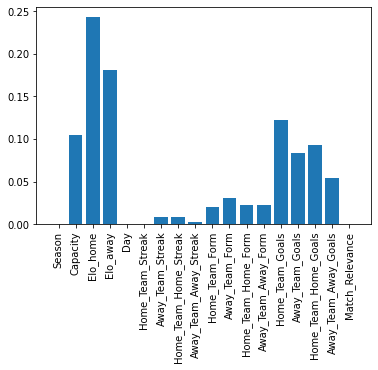

In [4]:
from matplotlib import pyplot as plt
plt.xticks(rotation=90)
plt.bar(list(X), models[1][1].feature_importances_)

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

cv = KFold(n_splits=10, random_state=1, shuffle=True)
print(cross_val_score(models[0][1], X, y, cv=cv, n_jobs=-1, scoring='accuracy'))

[0.61017812 0.61231552 0.60875318 0.6086514  0.60956743 0.61842239
 0.60732824 0.61156352 0.6082044  0.60922231]


In [23]:
tscv = TimeSeriesSplit(n_splits=10)
print(cross_val_score(models[0][1], X, y, cv=tscv, n_jobs=-1, scoring='accuracy'))

[0.59690964 0.59052738 0.59467025 0.6003807  0.6161684  0.60911432
 0.61829582 0.61672825 0.61583249 0.63184414]


In [25]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [28]:
btscv = BlockingTimeSeriesSplit(n_splits=10)
print(cross_val_score(models[0][1], X, y, cv=btscv, n_jobs=-1, scoring='accuracy'))

[0.58473282 0.60101781 0.5821883  0.5735369  0.6178117  0.60458015
 0.63664122 0.62137405 0.60559796 0.64580153]


https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

In [41]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

for i in range(100):

    finder = GridSearchCV(
            LogisticRegression(),
            param_grid=params,
            scoring='accuracy',
            refit=False,
            cv=cv,
            verbose=1,
            pre_dispatch=8,
            error_score=-999,
            return_train_score=True
    )

    finder.fit(X_train, y_train)

    best_params = finder.best_params_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -999.000000. Details: 
Traceback (most recent call last):
  File "/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jonny/miniconda3/lib/py

KeyboardInterrupt: 

In [ ]:
### Nested Cross-Validation



from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Load the dataset
X_iris = load_iris().data
y_iris = load_iris().target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svr = SVC(kernel="rbf")

# Create inner and outer strategies
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Pass the gridSearch estimator to cross_val_score
clf = GridSearchCV(estimator=svr, param_grid=p_grid, cv=inner_cv)
nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv).mean(); print(nested_score)

tests

https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7

In [ ]:
from scipy.stats import wilcoxon
from sklearn.datasets import load_iris
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

# Load the dataset
X = load_iris().data
y = load_iris().target

# Prepare models and select your CV method
model1 = ExtraTreesClassifier()
model2 = RandomForestClassifier()
kf = KFold(n_splits=20, random_state=42)

# Extract results for each model on the same folds
results_model1 = cross_val_score(model1, X, y, cv=kf)
results_model2 = cross_val_score(model2, X, y, cv=kf)

# Calculate p value
stat, p = wilcoxon(results_model1, results_model2, zero_method='zsplit'); p

In [ ]:
import numpy as np
from mlxtend.evaluate import mcnemar_table, mcnemar

# The correct target (class) labels
y_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Class labels predicted by model 1
y_model1 = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
                     0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1])

# Class labels predicted by model 2
y_model2 = np.array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
                     1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

# Calculate p value
tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model1, 
                   y_model2=y_model2)
chi2, p = mcnemar(ary=tb, exact=True)

print('chi-squared:', chi2)
print('p-value:', p)

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from mlxtend.data import iris_data

# Prepare data and clfs
X, y = iris_data()
clf1 = ExtraTreeClassifier()
clf2 = DecisionTreeClassifier()

# Calculate p-value
t, p = paired_ttest_5x2cv(estimator1=clf1,
                          estimator2=clf2,
                          X=X, y=y,
                          random_seed=1)